# 771948_A23_T3A - Group Work Assignment #
# Task 2 - Multi-label image-based digit classification problem #
## Assignment by Chris Mintz 202369825 and Antonia Agunbiade 202375309 ##

---
### Additional notes from class chat ###
#### 1. Labels from dataset will be folder names
#### 2. Beware of the multi image model classifying into triplets instead of single digits. The output shape should be 1000 instead of 10
#### 3. DO NOT recombine the split data. It has to be used as is as per TA Khadjia
#### 4. From Khadjia: The provided splits into training, validation and testing were designed to simulate real-world scenarios. Teams must develop a baseline model using these splits and gthen improve upon this baseline through various techniques such as preprocessing and model architecture enhancements.
---

# Task 6 - Load and preprocess the dataset for multi-label image-based digit classification task

## <b>References</b>

Johns, Ray. (2024). PyTorch vs TensorFlow for your Python Deep Learning Project. Available at: https://realpython.com/pytorch-vs-tensorflow/. [Accessed Aug 5, 2024]

In [30]:
# For this assignment we have chosen to use the TensorFlow over PyTorch as TensorFlow 2.0 has eager execution and the Keras APIs have more prefabricated components for us to use.
import tensorflow as tf
# TO DO: we might be able to remove this global import
from tensorflow import keras
# Needed for image pre-processing
from PIL import Image
# there is a lint problem access problem with the latest release of TensorFlow/Keras so we have to go direct to the root call
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input

# Change directory location as needed. This should be the root of the unzipped dataset and the initial folder visible shuold be "triple_mnist" 
# -------------------------------------------
dataset_root_dir = 'z:'
# -------------------------------------------

# Define our data split directory locations
training_dir = dataset_root_dir + '/triple_mnist/train'
validate_dir = dataset_root_dir + '/triple_mnist/val'
test_dir = dataset_root_dir + '/triple_mnist/test'

# Define our image parameters
image_height = 84
image_width = 84
batch_size = 32
# these are grayscale images, so we will only have 1 channel and this will be enforced in the data loading process
channels = 1
# output classes will be 0 to 9 which = 10
num_classes = 10
#TODO: Optimize
epochs = 10

# Data augmentation and preprocessing parameters to initialize the ImageDataGenerator
# Transformations we are NOT using include: zoom_range, horizontal_flip, vertical_flip, fill_mode, channel_shift_range, brightness_range, zca_epsilon, zca_whitening
# Note that we had the opportunity to use the "preprocessing_function" parameter to crop the images as needed but we chose to persist the cropped images to disk to prevent
# this function from being called with each epoch. This is because the cropping function is computationally expensive and we only need to do it once.
idg = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    shear_range=0.2,         # Apply shear transformations
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,   # Randomly shift images vertically by up to 20% of the height
)

## Pre-processing to get the triplet data into single values
### The data came to us as a series of triplet hand written numbers meaning that in the 84 x 84 image there are three images. Upon inspection there is a clean divide between all digits despite them having random y placement in the frame. Our best approach is to take the file name, divide the image into three and then save out the single hand written digit to a new folder. To manage this in memory could be costly so we will check if the images exist on your disk, write them if necessary, but read them from pre-processesd state if they have already been cleaned in your local dataset. We will watch for images that get cropped but even that might be only a couple of pixels.

In [34]:
# this is the function will crop a triplet digit image into three separate images and return them as a list of three images.
# this function does not manage disk persistence, it is only for in-memory processing
def crop_image(image):
    image_return = []
    x_cropsize = 28
    y_cropsize = 84
    x_croplength = x_cropsize/2
    y_croplength = y_cropsize/2
    # define the centers of the three cropped images and the crop size will go to the edge coords from there
    x_centers = [14, 42, 70]
    y_centers = [42, 42, 42]
    # create the three cropped images
    for i in range(3):
        image_return[i] = image.crop((x_centers[i]-x_croplength, y_centers[i]-y_croplength, x_centers[i]+x_croplength, y_centers[i]+y_croplength))
        
    return image_return

Found 64000 images belonging to 640 classes.


AttributeError: 'numpy.ndarray' object has no attribute 'crop'

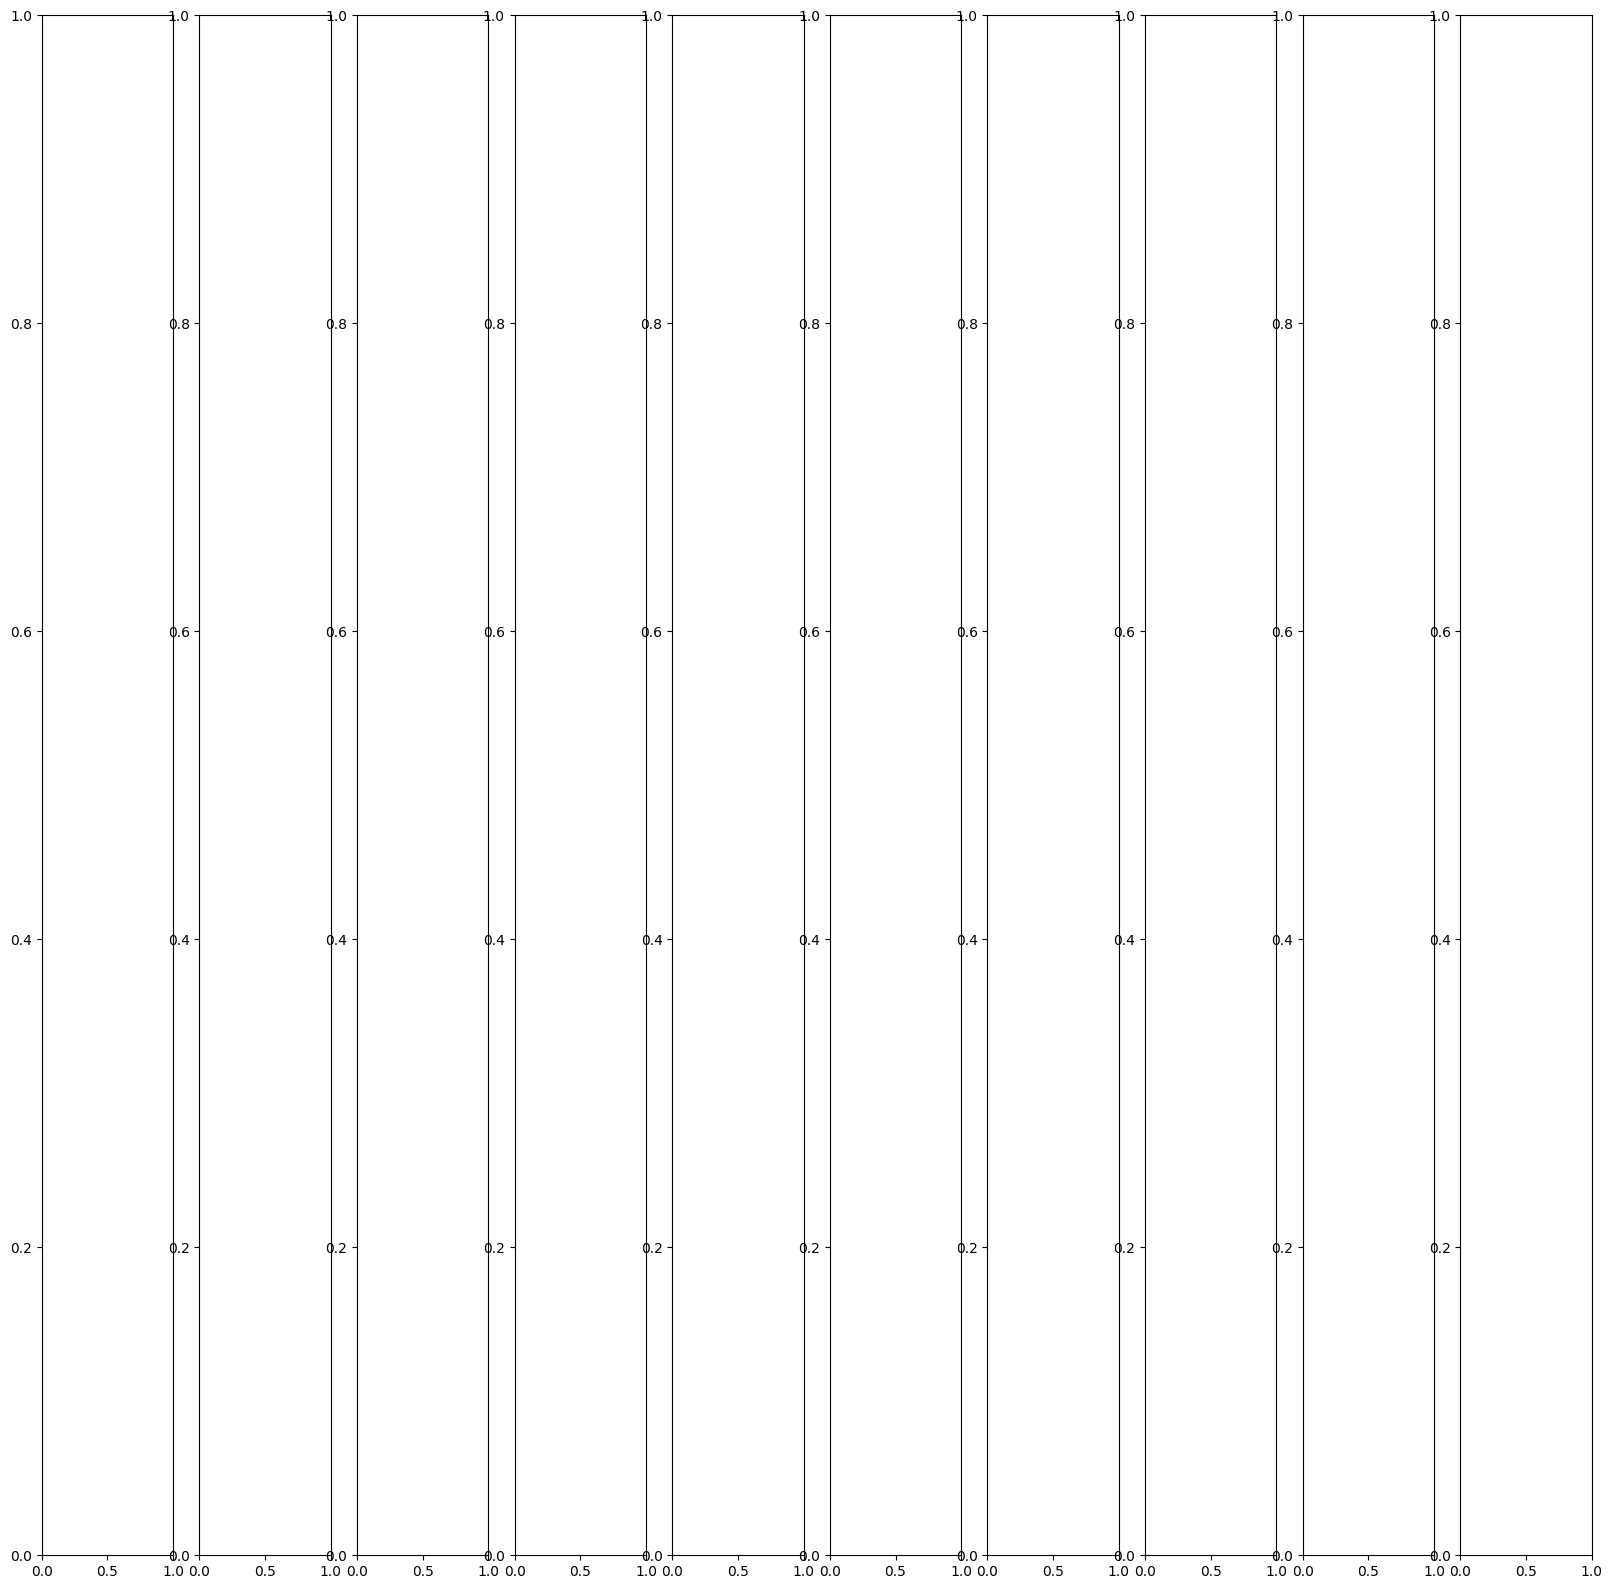

In [33]:
crop_generator = idg.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

# let's peek into the dataset
import matplotlib.pyplot as plt
import numpy as np
# Display the first 10 digits in the training training_generator
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(np.squeeze(crop_generator[0][0][i]), cmap='gray')
    ax[i].set_title(f'Label: {crop_generator[0][1][i]}')
    ax[i].axis('off')
plt.show()


In [ ]:
#TODO: This code can be trashed as all it does is draw a bounding box. Maybe make it a def function?
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load an image
image_path = training_dir + "/175/11_175.png"
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=1)
image = tf.image.resize(image, [84, 84])

# Define bounding boxes (normalized coordinates: [y_min, x_min, y_max, x_max])
bounding_boxes = tf.constant([[0.1, 0.1, 0.5, 0.5], [0.6, 0.6, 0.9, 0.9], [0.2, 0.3, 0.8, 0.7]])

# Convert bounding boxes to pixel coordinates
image_height, image_width, _ = image.shape
bounding_boxes_pixel = bounding_boxes * [image_height, image_width, image_height, image_width]

# Visualize the bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image.numpy().astype("uint8"))

for box in bounding_boxes_pixel:
    y_min, x_min, y_max, x_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [ ]:
#TODO: Problem is that the images are triplets and we need to load them as inidividual numbers
# Load the images from a locally mapped source (see README.md for details on setting up local drive mapping)
# We've used the idg to load only the training images and preprocess them with the above parameters
# Images are brought in as grayscale (single channel) as they are black and white images
training_generator = idg.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Our test and validation data should not be augmented so their init is simpler and does not use our predefined idg parameters
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Note use of validation data but no augmentation
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validate_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

In [ ]:
# check and see if all the images are the same shape before feeding them into the model
print(f'training generator shape {training_generator.image_shape}')
print(f'validation generator shape {validation_generator.image_shape}')
print(f'test generator shape {test_generator.image_shape}')


In [ ]:
# let's peek into the dataset
import matplotlib.pyplot as plt
import numpy as np
# Display the first 10 digits in the training training_generator
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(np.squeeze(training_generator[0][0][i]), cmap='gray')
    ax[i].set_title(f'Label: {training_generator[0][1][i]}')
    ax[i].axis('off')
plt.show()


# Task 7 - Build a convultional neural network (CNN) model for the multi-label image-based digit classification task

In [ ]:
#TODO: Don't forget to use Dropout layers to prevent overfitting
# Model setup
model = Sequential()
model.add(Input(shape=(image_height, image_width, channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
# Adjust the final layer to match the target shape
model.add(Dense(640, activation='softmax'))

# Show the model summary and ensure the final layer count matches our desired output of 10 as defined in the final Dense layer.
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Time to fit the model
model.fit(training_generator, epochs=1, validation_data=validation_generator)

In [ ]:
# Parked model for now
model.fit(
        training_generator,
        steps_per_epoch=training_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=1)

# Task 8 - Fine-tune the CNN model using appropriate techniques like hyperparameter tuning, cross-validation, etc

# Task 9 - Visualize the dataset and the CNN model's results where applicable with feature maps, learning curves, etc

# Task 10 - Report the final performance of the CNN model using appropriate performance metrics like accuracy, F1-score, etc

# Task 11 -Decide on the best model for classification and CNN architecture for digital recognition